In [1]:

# Importar librerías
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Cargar dataset
file_path = "/content/dataset_final_2017_model.csv"
df = pd.read_csv(file_path, encoding="utf-8")
print("Dimensiones iniciales:", df.shape)


Dimensiones iniciales: (6124, 82)


In [2]:
# Eliminar columnas irrelevantes y metadatos
cols_to_drop = [
    "station_rank_used", "station_active_2017", "station_provincia", "Province",
    "Code (CORINE Land Cover Code Level 1)", "Code (Land cover class code)", "LCC",
    "No (Number of horizons in the profile)", "No (Number of horizons in the profile).1",
    "Location", "Description (Vegetation details provided b...)", "nearest_station",
    "station_name", "cultivo"
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Eliminar columnas sin variabilidad
df = df.drop(columns=[col for col in df.columns if df[col].nunique() <= 1])

# Imputación de nulos
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [3]:
# Codificar variables categóricas relevantes
cat_cols_to_encode = [
    "Orientation",
    "Parent material (Parent material by original r...)",
    "Parent material (Parent material consistency)",
    "Parent material (Parent material silica content)",
    "Classification (Soil classification into WRB ...)",
    "Classification (Soil classification into USDA...)",
    "cultivo_grupo"
]

label_encoders = {}
for col in cat_cols_to_encode:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Eliminar IDs, duplicados y redundancias
cols_to_drop_final = [
    "profile_id", "Sample ID (Unique identification number ...).1", "Date",
    "UTM east [m]", "UTM north [m]", "lat", "lon",
    "No (Number of horizons in the pro...)", "No (Number of horizons in the pro...).1"
]
df = df.drop(columns=[c for c in cols_to_drop_final if c in df.columns])

df = df.drop(columns=[col for col in df.columns if "median" in col.lower()])

df = df.drop(columns=[
    "Parent material (Parent material silica content)",
    "toc_mean",
    "depth_sed_m_mean"
], errors="ignore")

print("Dimensiones finales del dataset:", df.shape)
print("Tipos de datos:\n", df.dtypes.value_counts())
print("Primeras columnas:", df.columns.tolist()[:15], "...")

Dimensiones finales del dataset: (6124, 37)
Tipos de datos:
 float64    29
int64       8
Name: count, dtype: int64
Primeras columnas: ['Latitude', 'Longitude', 'Depth sed [m]', 'Code (CORINE Land Cover Code Level 2-3)', 'Altitude [m]', 'Orientation', 'Perc [%] (Of Slope)', 'Parent material (Parent material by original r...)', 'Parent material (Parent material consistency)', 'Classification (Soil classification into WRB ...)', 'Classification (Soil classification into USDA...)', 'cultivo_grupo', 'distance_km', 'depth_top_m_mean', 'depth_bot_m_mean'] ...


In [4]:
# Guardar dataset limpio
df.to_csv("dataset_limpio.csv", index=False)

# Descargar dataset limpio
from google.colab import files
files.download("dataset_limpio.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, balanced_accuracy_score

# Cargar dataset limpio
file_path = "/content/dataset_limpio.csv"
df = pd.read_csv(file_path)

In [7]:
# Separar features y target
X = df.drop(columns=["cultivo_grupo"])
y = df["cultivo_grupo"]

# Renombrar columnas para evitar errores en XGBoost
X_renamed = X.copy()
X_renamed.columns = [f"feature_{i}" for i in range(X.shape[1])]

# Guardar diccionario de correspondencia
feature_mapping = dict(zip(X_renamed.columns, X.columns))

# Crear split de train/test estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_renamed, y, test_size=0.2, stratify=y, random_state=42
)

# Definir métricas personalizadas
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "balanced_acc": make_scorer(balanced_accuracy_score)
}

In [8]:
# Modelos a comparar
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", class_weight="balanced", max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", eval_metric="mlogloss",
        random_state=42
    )
}

# Estandarización para modelos sensibles a la escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Evaluación con validación cruzada
results = {}
for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        X_use = X_train_scaled
    else:
        X_use = X_train
    scores = cross_validate(
        model, X_use, y_train, cv=cv, scoring=scoring, error_score="raise"
    )
    results[name] = {
        "f1_macro": np.mean(scores["test_f1_macro"]),
        "recall_macro": np.mean(scores["test_recall_macro"]),
        "balanced_acc": np.mean(scores["test_balanced_acc"])
    }

# Mostrar resultados
results_df = pd.DataFrame(results).T
print("Resultados promedio en validación cruzada:\n")
print(results_df.sort_values(by="f1_macro", ascending=False))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/u

Resultados promedio en validación cruzada:

                     f1_macro  recall_macro  balanced_acc
XGBoost              0.496336      0.484749      0.484749
Random Forest        0.438331      0.411501      0.411501
SVM                  0.304335      0.393414      0.401152
Logistic Regression  0.241989      0.360813      0.379454


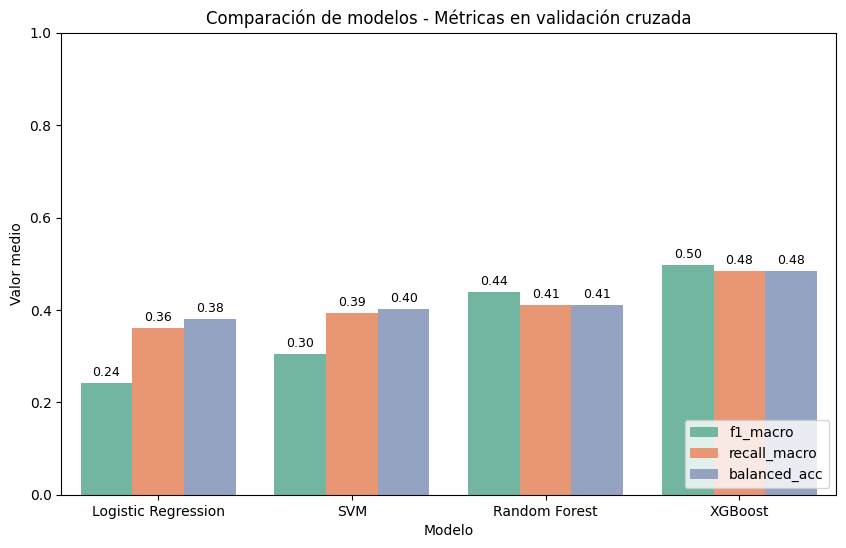

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización comparativa de métricas entre modelos con valores encima
results_plot = results_df.reset_index().melt(id_vars="index", var_name="Métrica", value_name="Valor")
results_plot = results_plot.rename(columns={"index": "Modelo"})

plt.figure(figsize=(10,6))
ax = sns.barplot(data=results_plot, x="Modelo", y="Valor", hue="Métrica", palette="Set2")

# Añadir valores encima de las barras (solo si son mayores a 0.01)
for p in ax.patches:
    height = p.get_height()
    value = round(height, 2)
    if value > 0.01:  # evita mostrar ceros pequeños
        ax.annotate(f"{value:.2f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center", va="bottom", fontsize=9, color="black",
                    xytext=(0, 3), textcoords="offset points")

plt.title("Comparación de modelos - Métricas en validación cruzada")
plt.ylabel("Valor medio")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

In [14]:
# Importar librerías adicionales
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar SMOTE solo en el conjunto de entrenamiento
smote = SMOTE(random_state=42, k_neighbors=1
              )
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Tamaño original del train:", X_train.shape, "→ Balanceado:", X_train_bal.shape)

Tamaño original del train: (4899, 36) → Balanceado: (35721, 36)


In [15]:
# Definir el modelo base
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:31:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores parámetros encontrados: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           2       0.90      0.88      0.89       125
           3       0.33      0.14      0.20         7
           4       0.33      0.20      0.25         5
           5       0.97      0.99      0.98       425
           6       0.67      0.25      0.36         8
           7       0.91      0.96      0.94       253
           8       0.71      0.50      0.59        10
           9       0.81      0.69      0.75        36
          10       0.40      0.22      0.29         9
          12       1.00      0.33      0.50         3
          13       0.33      0.40      0.36         5
          14       0.00      0.00      0.00         1
          15       0.77      0.87      0.81       142
          16       0.00      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


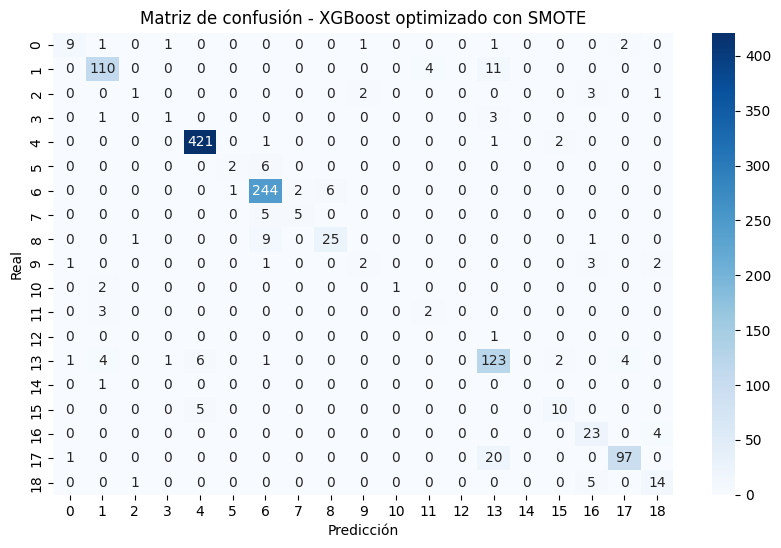

In [16]:
# RandomizedSearchCV para optimización
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenar con train balanceado
search.fit(X_train_bal, y_train_bal)

print("Mejores parámetros encontrados:", search.best_params_)

# Evaluar en test set
y_pred = search.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - XGBoost optimizado con SMOTE")
plt.show()

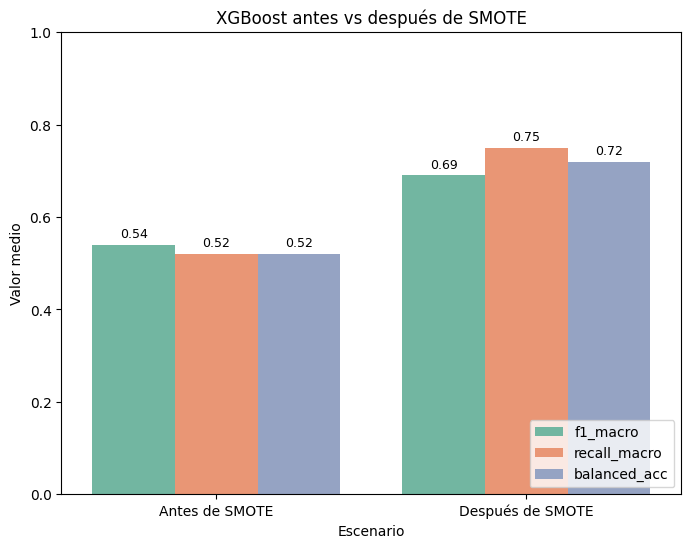

In [17]:
# Resultados XGBoost antes y después de aplicar SMOTE
# (rellena con tus valores reales si los tienes distintos)
xgb_results = pd.DataFrame({
    "Escenario": ["Antes de SMOTE", "Antes de SMOTE", "Antes de SMOTE",
                  "Después de SMOTE", "Después de SMOTE", "Después de SMOTE"],
    "Métrica": ["f1_macro", "recall_macro", "balanced_acc",
                "f1_macro", "recall_macro", "balanced_acc"],
    "Valor": [0.54, 0.52, 0.52,   # resultados antes de SMOTE
              0.69, 0.75, 0.72]   # resultados después de SMOTE (ejemplo, ajusta con los tuyos)
})

plt.figure(figsize=(8,6))
ax = sns.barplot(data=xgb_results, x="Escenario", y="Valor", hue="Métrica", palette="Set2")

# Añadir valores encima de las barras (solo si son mayores a 0.01)
for p in ax.patches:
    height = p.get_height()
    value = round(height, 2)
    if value > 0.01:
        ax.annotate(f"{value:.2f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center", va="bottom", fontsize=9, color="black",
                    xytext=(0, 3), textcoords="offset points")

plt.title("XGBoost antes vs después de SMOTE")
plt.ylabel("Valor medio")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

Top 15 variables más importantes en la predicción de cultivos:

                                              Feature  Importance
3             Code (CORINE Land Cover Code Level 2-3)    0.185869
24                                        k_mgkg_mean    0.073375
7   Parent material (Parent material by original r...    0.053773
30                                            gp_mean    0.053073
33                                     tmin_mean_2017    0.041877
15                                  density_gcm3_mean    0.034809
5                                         Orientation    0.034520
29                                        ec_msm_mean    0.033639
32                                     tmax_mean_2017    0.033533
1                                           Longitude    0.030708
31                                     tmed_mean_2017    0.028336
22                                       tn_mgkg_mean    0.026148
25                                       ca_mgkg_mean    0.025294
20          

/tmp/ipython-input-3645172542.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15), palette="viridis")


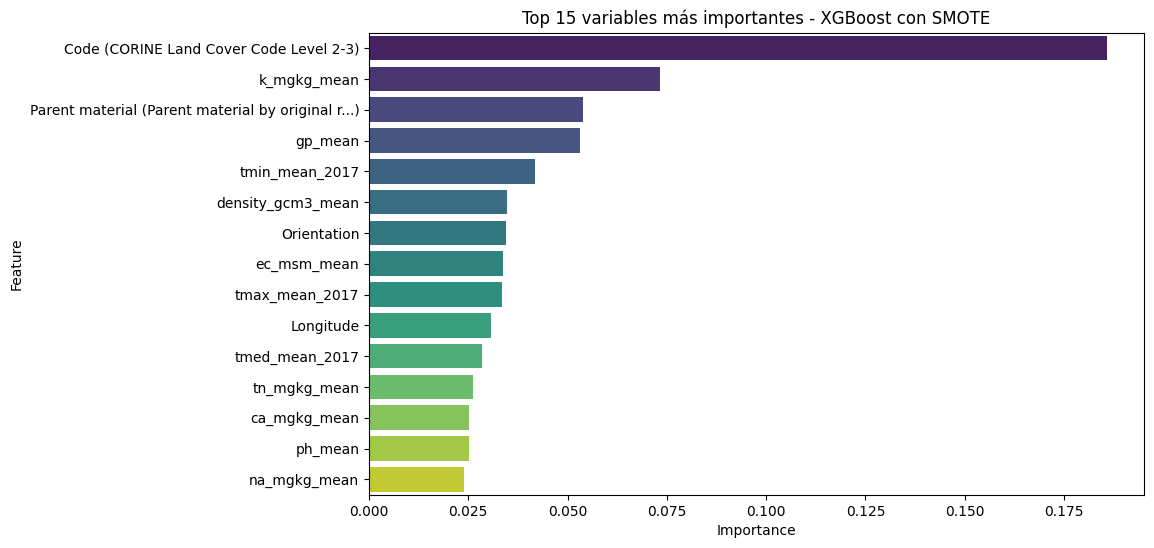

In [18]:
# Extraer el mejor modelo entrenado de la búsqueda
best_xgb = search.best_estimator_

# Importancia de features
importances = best_xgb.feature_importances_

# Mapear a nombres originales de columnas
feature_importance_df = pd.DataFrame({
    "Feature": [feature_mapping[f] for f in X_train.columns],
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Mostrar top 15 features más importantes
print("Top 15 variables más importantes en la predicción de cultivos:\n")
print(feature_importance_df.head(15))

# Visualización
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15), palette="viridis")
plt.title("Top 15 variables más importantes - XGBoost con SMOTE")
plt.show()
